<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Question-1" data-toc-modified-id="Question-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Question 1</a></span></li><li><span><a href="#Question-2" data-toc-modified-id="Question-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Question 2</a></span></li><li><span><a href="#Question-3" data-toc-modified-id="Question-3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Question 3</a></span><ul class="toc-item"><li><span><a href="#Generate-and-visualize-the-dataset" data-toc-modified-id="Generate-and-visualize-the-dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generate and visualize the dataset</a></span></li><li><span><a href="#Visualisation-of-dataset" data-toc-modified-id="Visualisation-of-dataset-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Visualisation of dataset</a></span></li><li><span><a href="#Implementation-of-Gaussian-Mixture-Model" data-toc-modified-id="Implementation-of-Gaussian-Mixture-Model-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Implementation of Gaussian Mixture Model</a></span></li></ul></li></ul></div>

ZHU Fangda

In [1]:
%reset -f

In [2]:
%load_ext line_profiler

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.linalg import cholesky
from scipy.stats import multivariate_normal, norm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture
%matplotlib notebook

# Question 1

<div class="alert alert-info">

In Gaussian Mixture Models, we often need to evaluate quantities that are defined as follows:
<br>

\begin{equation}
\gamma_i(x) = \frac{ \pi_i \mathcal{N}(x;\mu_i, \Sigma_i)}{\sum_{j=1}^K \pi_j \mathcal{N}(x ; \mu_j, \Sigma_j)}
\end{equation}
<br>
where $\pi_i \in [0,1]$ and $\mathcal{N}$ denotes the multivariate Gaussian distribution. A direct computation of these quantities might be problematic in practice since all the terms $\pi_i \mathcal{N}(x;\mu_i, \Sigma_i)$ might be very small, and we might end up with 0/0.   
<br>
Derive mathematically (don’t try to take the derivative!) and implement a function for numerically stable computation
of $\{\gamma_i\}_{i=1}^K$.  
<br>
Hint: first compute $l_i = \log \pi_i \mathcal{N}(x;\mu_i, \Sigma_i)$ in a numerically stable way (be careful when computing log det $\Sigma_i$). Then use a trick similar to the one we used for 'log sum exp'.
A</div>

In this report, we define $M$, the number of features, $K$, the number of distinct Gaussian distribution， and $N$, the number of samples.



According to the question,in order to avoid 0/0, we suppose that 
$$ l_i(x) = \ln\left(\pi_i  N\left(x;\mu_i,\Sigma_i\right)\right),i\in \mathbb[1,\dots,K]$$
We can write the formular like following:

$$
\begin{equation}
\begin{aligned}
\ln\gamma_i(x) &= l_i(x) - \ln\sum_{j=1}^K \exp{l_j(x)} \\
\end{aligned}
\end{equation}
$$
For the second item, we can apply the **logsumexp** trick.

Beside 
For each $l_i$, 

$\mathcal{N}(x;\mu_i,\Sigma_i)=\frac{e^{-\frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)}}{\sqrt{(2\pi)^M|\Sigma_i|}})$

So

$$
l_i = \ln(\pi_i)-\ln(N\left(x;\mu_i,\Sigma_i\right)
$$

$$
l_i=\ln{\pi_i}-\frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)-\frac{M}{2}\ln(2\pi)-\frac{1}{2}\ln{|\Sigma_i|}
$$
where 
$$
|\Sigma|= det |\Sigma| = \Sigma_{\sigma \in S_n} \left(sgn(\sigma)\prod_{i=1}^{M}a_{i,\sigma}\right)
$$
If the $\Sigma$ has a very small or very larg determinant, then a call <code>det</code>  may overflow or underflow. So we have to find a method to avoid this problem.

This covariance matrix is a Hermitian positive-definite matrix. So we can apply the **Chokosky decomposition** and get
$$
\Sigma = LL^T = LU
$$
where $L$ is a lower triangular matrix and $U=L^T$ is a higher triangular matrix.So we can get 
$$
\det(\Sigma) = \det(LU)=\det(U)\det(L)=\prod \limits_{i=1}^{M}L_{i,i}\prod \limits_{i=1}^{M}U_{i,i}= \prod \limits_{i=1}^{M}L_{i,i}^2
$$
Thus
$$
\begin{aligned}
\ln|\Sigma| &= \ln|\prod \limits_{i=1}^{M}L_{i,i}^2| \\
&= 2\sum \limits_{i=1}\ln|L_{i,i}| \\
\end{aligned}
$$

In [6]:
def log_det(sgiam):
    '''
    Compute the determinant with a stable way.
    Params:
        sigma : the input matrix. This matrix must positif-definite
        
    Returns:
        det : determinant of simage
    
    '''
    L = cholesky(sigma, lower=True)
    return 2*np.sum(np.log(np.diag(L)))

In [7]:
# Test for the log_det method
sigma = np.array([[0.5, 0.25], [0.25, 0.5]]) / 1000000000000000000
np.allclose(log_det(sigma), np.log(np.linalg.det(sigma)))

True

Thus
$$
l_i(x)=\ln{\pi_i}-\frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)-\frac{M}{2}\ln(2\pi)-\sum \limits_{j=1}^{M}\ln|L_{j,j}| 
$$

Due to,
$$
\Sigma^{-1} = (L^T)^{-1}L = (L^{-1})^TL^{-1}
$$
We can contiue to simplify our formular by replacing $\Sigma^{-1}$ with $(L^{-1})^TL$, and we get
$$
l_i(x)=\ln{\pi_i}-\frac{1}{2}||L^{-1}(x-\mu_i)||^2-\frac{M}{2}\ln(2\pi)-\sum \limits_{j=1}^{M}\ln|L_{j,j}| 
$$

In [8]:
def log_gamma(x, pi, mu, sigma,):
    N = x.shape[0]
    items1 = np.log(pi)-N*0.5*np.log(2*np.pi)
    
    L = cholesky(sigma, lower=True)
    L_inv = np.linalg.inv(L)
    items2 = 0.5 * np.sum(L_inv.dot(x-mu)**2)
    items3 = np.sum(np.log(np.abs(np.diag(L))))
    return items1 -items2 - items3

In [9]:
# Test for the log_gamma function
X = -4 * np.array(list(np.ndindex(100, 100))) / 100 + 2
pi = [0.3, 0.2, 0.5]
mu = np.array([[0, 0], [1, 2], [2, 0]])
sigma = np.array([[[1., -0.25], [-0.25, 0.5]], [[0.5, 0.25], [0.25, 0.5]],
                  [[0.5, -0.25], [-0.25, 1]]])

In [8]:
for x in X:
    for i in range(3):
        for j in range(3):
            for k in range(3):
                test_val = log_gamma(x, pi[i], mu[j], sigma[k])
                except_val = np.log(pi[i] * stats.multivariate_normal.pdf(
                    x, mean=mu[j], cov=sigma[k]))
                if(not np.allclose(test_val, except_val)):
                    print(x,pi[i],mu[i], sigma[k])
                    print(('Excepted value:', except_val, 'Test value:', test_val))

According to the test, our function is correct. But the following test prove that our funciton is more robust when the covariance is very small.

D:\Users\zhufa\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


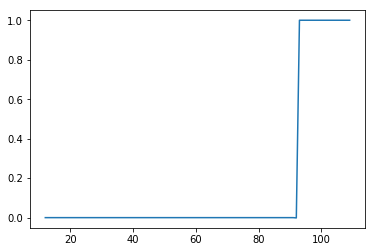

In [15]:
sigma = np.array([[1., -0.25], [-0.25, 0.5]])
diff = []
except_vals = []
test_vals = []

x = range(10,120,1)
for i in x:
    except_val = np.log(pi[1]*stats.multivariate_normal.pdf(X[5], mean=mu[0], cov=sigma/i))
    test_val = log_gamma(X[5], pi[1], mu[0], sigma/i)
    diff.append(test_val - except_val)
    except_vals.append(except_val)
    test_vals.append(test_val)
    
diff = [1 if x == np.inf else x for x in diff]
except_vals = [1 if x == -np.inf else x for x in except_vals]
test_vals = [1 if x == -np.inf else x for x in test_vals]    
plt.plot(x[2:100],diff[2:100])

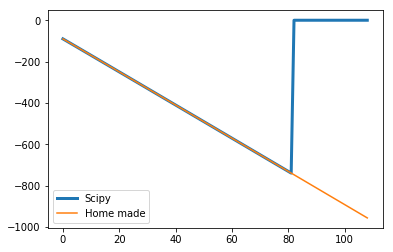

In [18]:
plt.plot(except_vals[1:], lw=3, label='Scipy')
plt.plot(test_vals[1:], label ='Home made')
plt.legend()

When the covriance is enought small, the gamma gotten by **stats.multivariate_normal.pdf** become **-inf**, but our implementation can always get the values. So our implemention is more robust.

# Question 2

<div class="alert alert-info" role="alert">

Let us consider a Gaussian Mixture Model (GMM), given as follows:
<br>

\begin{equation}
p(x_n) = \sum_{i=1}^K \pi_i \mathcal{N}(x_n ; \mu_i, \Sigma_i)
\end{equation}

where $\{x_n\}_{n=1}^N $ is a set of observed data points. 

<br>Derive the M-Step of the Expectation-Maximization algorithm for this model, to find $\pi_{1:K}^{(t+1)}, \mu_{1:K}^{(t+1)}, \Sigma_{1:K}^{(t+1)}$, where $t$ denote the iteration number.
</div>

The Gaussian Mixtures Model give a linear super-position of Gaussians:
$$
p(x_n)=\sum\limits_{i=1}^{K}\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)
$$

Considerlog likehood:
<div class="card-body">
$$
\begin{align}
\ln p(X) &=  \underset{\mu_i, \Sigma_i}{argmax} \Sigma^N_{n=1}\ln p(x_n) \\
&= \sum\limits_{n=1}^N \underset{\mu_i, \Sigma_i}{argmax} \;\ln \left(\sum\limits_{i=1}^{K} \pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)\right) 
\end{align}
$$

- For the means, we need

- $\frac{\partial{\ln p(X)}}{\partial{\mu_i}} = 0$

$$
\begin{equation}
\begin{aligned}
\frac{\partial{\ln p(x_n)}}{\partial{\mu_i}} &= \frac{1}{\sum\limits_{i=1}^{K}p(x_n|\pi_i,\mu_i,\Sigma_i)}\frac{\partial\sum\limits_{i=1}^{K}p(x_n|\pi_i,\mu_i,\Sigma_i)}{\partial\mu_k} \\
&= \frac{1}{\sum\limits_{i=1}^{K}\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}\frac{\partial\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}{\partial\mu_i}\\
&= \frac{1}{\sum\limits_{i=1}^{K}\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}\frac{\frac{\pi_ie^{-\frac{1}{2}(x_n-\mu_i)^T\Sigma_k^{-1}(x_n-\mu_i)}}{\sqrt{(2\pi)^k|\Sigma_i|}}}{\partial \mu_i} \\
&=\frac{\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}{\sum\limits_{i=1}^{K}\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}(-\Sigma_i^{-1}(x_n-\mu_i))\\
&=\gamma_i(x_n)\Sigma_i^{-1}(x_n-\mu_i) \\
\end{aligned}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
\frac{\partial{\ln p(X)}}{\partial{\mu_i}} &= \sum\limits_{n=1}^{N}\gamma_i(x_n)\Sigma_i^{-1}(x_n-\mu_i)
\end{aligned}
\end{equation}
$$
Thus 

$$\fbox{$\mu_i=\frac{\sum\limits_{n=1}^{N}\gamma_i(x_n)x_n}{\sum\limits_{n=1}^{N}\gamma_i(x_n)}$}$$

For the covariance : we need
$$
\frac{\partial{logp(X)}}{\partial{\pi_i}} =0
$$

With the same methode, we hava
$$\frac{\partial{\ln p(X)}}{\partial{\Sigma_i}}=\sum\limits_{n=1}^{N}\gamma_i(x_n)((x_n-\mu_i)(x_n-\mu_i)^T-\Sigma_i)=0$$

Thus

$$\fbox {$\Sigma_i=\frac{\sum\limits_{n=1}^{N}\gamma_i(x_n)((x_n-\mu_i)(x_n-\mu_i)^T}{\sum\limits_{n=1}^{N}\gamma_i(x_n)}$}$$


For the $\pi$, we need 
Because $\sum\limits_{i=1}^{K}\pi_i=1$ ans $\pi_i>0$, we add a Lagrange multiplier.Let

$$
\begin{equation}
\begin{aligned}
\frac{\partial{[logp(X)+\lambda(\sum\limits_{i=1}^{K}\pi_i-1)]}}{\partial{\pi_i}}&= 0 \\
\sum\limits_{n=1}^{N}\frac{\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}{\sum\limits_{i=1}^{K} \pi_j\mathcal{N}(x_n;\mu_j,\Sigma_j)}+ \pi_i\lambda &= 0 \\
\sum\limits_{i=1}^{K}\sum\limits_{n=1}^{N}\frac{\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}{\sum\limits_{i=1}^{K} \pi_j\mathcal{N}(x_n;\mu_j,\Sigma_j)}+ \sum\limits_{i=1}^{K}\pi_i\lambda &= 0 \\
\sum\limits_{n=1}^{N}\sum\limits_{i=1}^{K}\frac{\pi_i\mathcal{N}(x_n;\mu_i,\Sigma_i)}{\sum\limits_{i=1}^{K} \pi_j\mathcal{N}(x_n;\mu_j,\Sigma_j)}+ \lambda &= 0 \\
N+ \lambda &= 0 \\
\lambda &= -N \\
\end{aligned}
\end{equation}
$$

We we multiply  $\pi_i$  to both sides of the equation and get:


$\lambda+\sum\limits_{n=1}^{N}\sum\limits_{i=1}^{K}\gamma_i(x_n)=0 \rightarrow \lambda=-N$

Thus

$$\fbox{$\pi_i=\frac{\sum\limits_{n=1}^{N}\gamma_i(x_n)}{N}$}$$


# Question 3

<div class="alert alert-info">
Consider the model given in Equation 1. 
<br>
Set $K = 3$, $\pi_1 = 0.3$, $\pi_2 = 0.2$, $\pi3 = 0.5$, $\mu_1 = [0; 0]$, $\mu_2 = [1; 2]$, $\mu_3 = [2; 0]$,
$\Sigma_1 = [1.00, −0.25; −0.25, 0.50]$, $\Sigma_2 = [0.50, 0.25; 0.25, 0.50]$, $\Sigma_3 = [0.50, −0.25; −0.25, 1]$.
</div>

In [140]:
K,N = 3, 10
weight = [0.3, 0.2, 0.5]
mu = np.array([[0, 0], [1, 2], [2, 0]])
sigma = np.array([[[1., -0.25], [-0.25, 0.5]],
         [[0.5, 0.25], [0.25, 0.5]],
         [[0.5, -0.25], [-0.25, 1]]])

## Generate and visualize the dataset
<div class="alert alert-success">
Generate a dataset $\{x_n\}_{n=1}^N$ by using the model definition (set $N = 1000$). <br>Visualize the dataset.</div>

In [141]:
def generate_dataset(N, pi, mu, sigma):
    '''
    Generate dataset.
    
    Params:
    -------
        N : Number of samples
        pi : a array-list object containing weight for each distribution.
        mu : the means matrix with shape K*M where M is the number of feathre, K 
            is the number of the distributions
        sigma : a matrix containing the covariance of each distributions with 
            the shape K*M*M.
            
    Returns:
    --------
        df : a DataFrame cotaining all the features and the target.
    '''
    K, M = mu.shape
    data = np.zeros((N, M + 1))

    data[:, M] = np.random.choice( list(range(K)), p=pi, size=N)
    
    f = lambda x : multivariate_normal(mu[int(x[M]),:], sigma[int(x[M]), :, :]).rvs()

    data[:, :2] = np.apply_along_axis(f, axis=1, arr=data)

    df = pd.DataFrame(data, columns=['x', 'y', 'type'])
    df['type'] = df['type'].astype(np.int)

    return df

In [142]:
dataset = generate_dataset(N, weight, mu, sigma)
dataset.head()

,x,y,type
0,2.350964,-1.211021,2
1,1.180226,2.160575,1
2,2.552697,0.243246,2
3,0.848327,0.699632,0
4,1.906631,-0.175824,2


In [143]:
x  = np.arange(8).reshape(2,2,2)
x.sum(axis=2)

array([[ 1,  5],
       [ 9, 13]])

In [144]:
print("Mean:", mu)
print("var:", sigma)
pd.pivot_table(dataset, index='type', aggfunc=[np.mean, np.var])

Mean: [[0 0]
 [1 2]
 [2 0]]
var: [[[ 1.   -0.25]
  [-0.25  0.5 ]]

 [[ 0.5   0.25]
  [ 0.25  0.5 ]]

 [[ 0.5  -0.25]
  [-0.25  1.  ]]]


mean                 var          
             x         y         x         y
type                                        
0    -0.598060  0.471816  1.993485  0.168790
1     1.419237  2.588807  0.114253  0.366766
2     2.160958 -0.266152  0.120482  0.426516

## Visualisation of dataset

In [145]:
def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
                                  180 + angle, edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)
        ax.scatter(means[n,0], means[n,1], c='red', marker='x')

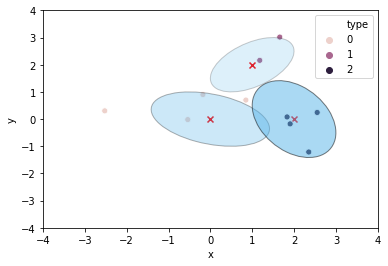

In [146]:
ax = plt.subplot()
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])
plot_ellipses(ax, pi, mu, sigma)
df = pd.DataFrame(X, columns=['x','y'])
sns.scatterplot(x="x", y="y", data=dataset, hue="type", ax= ax)
plt.show()

In [147]:
print(sudoku.strides)
print(array.strides)

(36, 4)
(40, 4)


In [148]:
# 数独是个 9x9 的二维数组
# 包含 9 个 3x3 的九宫格
sudoku = np.array([   
    [2, 8, 7, 1, 6, 5, 9, 4, 3],
    [9, 5, 4, 7, 3, 2, 1, 6, 8],
    [6, 1, 3, 8, 4, 9, 7, 5, 2],
    [8, 7, 9, 6, 5, 1, 2, 3, 4],
    [4, 2, 1, 3, 9, 8, 6, 7, 5],
    [3, 6, 5, 4, 2, 7, 8, 9, 1],
    [1, 9, 8, 5, 7, 3, 4, 2, 6],
    [5, 4, 2, 9, 1, 6, 3, 8, 7],
    [7, 3, 6, 2, 8, 4, 5, 1, 9]
])

# 要将其变成 3x3x3x3 的四维数组
# 但不能直接 reshape，因为这样会把一行变成一个九宫格
shape = (3, 3, 3, 3)

# 大行之间隔 27 个元素，大列之间隔 3 个元素
# 小行之间隔 9 个元素，小列之间隔 1 个元素
strides = sudoku.itemsize * np.array([27, 3, 9, 1])

squares = np.lib.stride_tricks.as_strided(sudoku, shape=shape, strides=strides) 
print(squares)


[[[[2 8 7]
   [9 5 4]
   [6 1 3]]

  [[1 6 5]
   [7 3 2]
   [8 4 9]]

  [[9 4 3]
   [1 6 8]
   [7 5 2]]]


 [[[8 7 9]
   [4 2 1]
   [3 6 5]]

  [[6 5 1]
   [3 9 8]
   [4 2 7]]

  [[2 3 4]
   [6 7 5]
   [8 9 1]]]


 [[[1 9 8]
   [5 4 2]
   [7 3 6]]

  [[5 7 3]
   [9 1 6]
   [2 8 4]]

  [[4 2 6]
   [3 8 7]
   [5 1 9]]]]


In [149]:
array = np.arange(100).reshape(10,10)
strides = array.itemsize * np.array([20, 2, 10, 1])
print(array)
square = np.lib.stride_tricks.as_strided(array, shape=(5,5,2,2) ,strides=strides)
print(square)
print('sum',square.sum(axis=(2,3)))

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]
[[[[ 0  1]
   [10 11]]

  [[ 2  3]
   [12 13]]

  [[ 4  5]
   [14 15]]

  [[ 6  7]
   [16 17]]

  [[ 8  9]
   [18 19]]]


 [[[20 21]
   [30 31]]

  [[22 23]
   [32 33]]

  [[24 25]
   [34 35]]

  [[26 27]
   [36 37]]

  [[28 29]
   [38 39]]]


 [[[40 41]
   [50 51]]

  [[42 43]
   [52 53]]

  [[44 45]
   [54 55]]

  [[46 47]
   [56 57]]

  [[48 49]
   [58 59]]]


 [[[60 61]
   [70 71]]

  [[62 63]
   [72 73]]

  [[64 65]
   [74 75]]

  [[66 67]
   [76 77]]

  [[68 69]
   [78 79]]]


 [[[80 81]
   [90 91]]

  [[82 83]
   [92 93]]

  [[84 85]
   [94 95]]

  [[86 87]
   [96 97]]

  [[88 89]
   [98 99]]]]
sum [[ 22  30  38  46  54]
 [102 110 118 126 134]
 [182 190 

In [150]:
def plot_kdn(weight,  mu, sigma):
#     fig = plt.figure()
#     ax = fig.gca(projection='3d')
    X = np.arange(-5, 5, 0.1)
    Y = np.arange(-5, 5, 0.1)
    pts = np.array(np.meshgrid(X, Y)).T.reshape(-1,2)
    
    Z = np.zeros(len(pts))
    g=[]
    X, Y = np.meshgrid(X, Y)
    for i in range(len(mu)):
        g.append(stats.multivariate_normal.pdf(pts, mu[i], sigma[i]))
        Z = Z + weight[i]*g[i]
    
    print(X.shape, Y.shape, Z.shape)
    
    
    plt.figure()    
    CS = plt.contour(X, Y, Z.reshape(100,100).T, 20)
    plt.clabel(CS, inline=1, fontsize=10)
    return plt.gca()
#     surf = ax.plot_surface(X, Y, Z.reshape(100,100), rstride=1, cstride=1, cmap=plt.get_cmap('coolwarm'),
#             linewidth=0, antialiased=True)
#     fig.colorbar(surf, shrink=0.5, aspect=5)

(100, 100) (100, 100) (10000,)


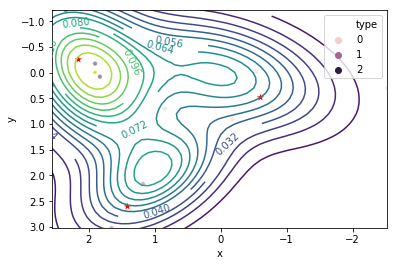

In [151]:
ax = plot_kdn(weight, mu, sigma)
ax.set_xlim([dataset.x.max(), dataset.x.min()])
ax.set_ylim([dataset.y.max(), dataset.y.min()])
ax = sns.scatterplot(x="x", y="y", data=dataset, hue="type", ax= ax,  s=20, alpha=0.5)
ax = sns.scatterplot(x='x', y='y', data=dataset.groupby(by = 'type').mean(), ax=ax, marker='*' ,color='r',s=100)

## Implementation of Gaussian Mixture Model

In [152]:
x = np.arange(9).reshape(3,3)
x.

SyntaxError: invalid syntax (<ipython-input-152-7de14fbd337d>, line 2)

In [153]:
class Gaussian_Mixture_Model:

    def log_gamma(self):
               
        
        Ls = [cholesky(sigma[i], lower=True) for i in range(self.K)]
        Ls_inv = np.vstack([np.linalg.inv(Ls[i])  for i in range(self.K)])
        print('Ls_inv shape should be (6,2)',Ls_inv.shape)
        
        Ls_diag = np.array([ np.log(np.diag(L)).sum() for L in Ls])
        
        items1 = np.log(pi)-self.nb_features*0.5*np.log(2*np.pi) - Ls_diag
        
        X_ = np.hstack([ (self.X - self.means[i]).T for i in range(self.K)])
        print('X_ shape should be (2,10)',X_.shape)
        
        item2 = Ls_inv.dot(X_)
        print('item2 shape should be (6,10)',item2.shape)
        
        N = x.shape(0)
        strides = item2.itemsize * np.array([self.nb_samples*self.nb_features, self.nb_features, 1, 1])
        X_brike = np.lib.stride_tricks.as_strided(item2, shape=(self.K, self.nb_samples, self.nb_features, 1))
        item3 = 0.5*np.sum(X_brike**2, axis=(2,3))
        print('item3 shape should be (3,10)',item2.shape)
        
        self.log_prob(items1 - item3.T).T 


    def _logsum(self, vals, axis=None, keepdims=False):
        if(axis==None):
            l_max = np.max(vals)
            return np.max(vals) + np.log(np.sum(np.exp(vals - l_max)))
        else:
            vals = vals.T if(axis ==1) else vals
            l_max = np.max(vals, axis=0)
            return l_max + np.log(np.sum(np.exp(vals - l_max), axis=0))
    
    
    def __init__(self, K, n_iter=1000, tol=1e-6, rand_state=None,
                 verbose=False):
        '''
        The GaussianMixture object implements the expectation-maximization (EM) 
        algorithm for fitting mixture-of-Gaussian models.

        Input:
        ------
            K : the number of cluster
            n_iter : int, default to 100. 
                The max number of EM iterations to perform.
            rand_state : int or None, default to None.
                int, random_state is the seed used by the random 
                number generator; 
                If None, the random number 
                generator is the RandomState instance used by np.random.
            verbose : bool, default to False.
                    Enable verbose output
        '''
        
        self.K, self.n_iter, self.tol = K, n_iter, tol
        self.rand_state, self.verbose = rand_state, verbose

        if (self.rand_state == None):
            self.uniform = np.random.uniform
        else:
            self.uniform = np.random.RandomState(rand_state).uniform

    def __init_param(self, X):
        '''
            Initialization of the parameter of distribution.
        '''

        self.nb_samples, self.nb_features = X.shape
        
        # weight for each gaussian distribution
        self.weight = np.random.rand(self.K)
        self.weight = self.weight / np.linalg.norm(self.weight, 1)
        
        self.X = np.array(X, dtype=np.float64)
        X_max = np.max(self.X)
        X_min = np.min(self.X)
        X_band = X_max - X_min
        
        self.covs = (X_max-X_min) * \
            self.uniform(size=(self.K,self.nb_features,self.nb_features))
        
        self.means = (X_max - X_min) * self.uniform(
            size=(self.K, self.nb_features)) + X_min
        
        for i in range(self.K):
            self.covs[i] = self.covs[i].dot(self.covs[i].T)
        self.weight = [0.3, 0.2, 0.5]
        self.means = np.array([[0, 0], [1, 2], [2, 0]])
        self.covs = np.array([[[1., -0.25], [-0.25, 0.5]],
                              [[0.5, 0.25], [0.25, 0.5]],
                              [[0.5, -0.25], [-0.25, 1]]])
        
        
        # Save gamma value for each condition, each line for a distribution,
        # column for the sample
        self.gamma = np.zeros(shape=(self.K,self.nb_samples))
        
        # p(i,j) = pi_i * N(x_j, means[i], mu[i])
        self.log_prob = np.zeros(shape=(self.K, self.nb_samples))
        self._get_prob()
        
        if (self.verbose):
            print(('Initial parameter: \n\t pi:\n{}, \n\tmean:\n{} \n\tcov:\n{}'.format(
                self.weight, self.means, self.covs)))
            
    
            
    def fit(self, X):
        self.__init_param(X)
        _old_likehood = 0
        self._likehood = [self._evaluation()]

        for cnt in range(self.n_iter):       
            self._e_step()
            self._m_step()
            self._get_prob()
            print(self.log_prob)
            self._likehood.append(self._evaluation())
            
            if (self.verbose):
                print(("Number iteration:{}, log likehood:{} diff:{:e}".format(
                    cnt, self.log_likehood, np.abs(self._likehood[cnt]-self._likehood[cnt-1]))))
            
            if( np.abs(self._likehood[cnt]-self._likehood[cnt-1]) < self.tol):
                break;
                
        
        if(self.verbose):
            print(('Initial value: \n ----------pi:\n{}, \n----------mean:\n{} \n----------cov:\n{}'.format(
                self.weight, self.means, self.covs)))
        
        

    def _e_step(self):
        diff = self.log_prob - np.max(self.log_prob, axis=0)
        self.gamma = diff - np.log(np.sum(np.exp(diff), axis=0))        


    def _m_step(self):
        max_gamma = np.max(self.gamma, axis=1)
        exp_diff = np.exp(self.gamma.T- max_gamma).T
        divisor = np.sum(exp_diff, axis=1)
        self.means = (exp_diff.dot(self.X).T / np.sum(exp_diff, axis=1)).T
#         print('mean',self.means)
        
        self.weight= np.exp(max_gamma) / self.nb_samples * np.sum(exp_diff, axis=1) 
#         print('weight', self.weight)
        
        for i in range(self.K):
#             print('X', self.X.shape, exp_diff[i,:].shape, (X - self.means[i]).shape )
            self.covs[i] = (exp_diff[i,:] * (self.X - self.means[i]).T).dot(self.X - self.means[i]) /  divisor[i]
            
#         print('cov',i, self.covs)
            

    def _get_prob(self):
        self.log_gamma()
        print('prob', self.log_prob)
        
    def predicate_proba(self, val_X):
        nb_val_sample = len(val_X)
        prob_matrix = np.zeros(shape=(self.K, len(val_X)))
                
        for k in range(self.K):
            for i in range(nb_val_sample):
                prob_matrix = self.log_gamma(val_X[i, :], self.weight[k], self.means[k], self.covs[k])
            
        return prob_matrix
    
    def predicate(self, val_X):
        predicate_proba(self, val_X)
        return np.argmax(prob_matrix, axis=0)
        
    def _evaluation(self):
        ## Max value for each xn
        max_col = np.max(self.log_prob,axis=0)
        self.log_likehood =  np.sum(max_col + np.log(np.sum(np.exp(self.log_prob - max_col), axis=0)))
        
        return self.log_likehood

    def __repr__(self):
        return self.__str__()

    def draw_result(self):
        ax = plt.subplot()
        ax.set_xlim([-4,4])
        ax.set_ylim([-4,4])
        plot_ellipses(ax, self.weight, self.means, self.covs)
        df = pd.DataFrame(self.X, columns=['x','y'])
        df['category'] = np.argmax(self.log_prob, axis=0)
        sns.scatterplot(x="x", y="y", data=df, hue="category", ax= ax)
        plt.show()

        
    def __str__(self):
        return "Gaussian_Mixture_Model(self, {}, n_iter = {}, tol={}, rand_state={}, verbose = {})".format(
            self.K, self.n_iter, self.tol, self.rand_state, self.verbose)

In [154]:
estimator1 = Gaussian_Mixture_Model( K, n_iter=100, tol=1e-4, rand_state=None,
                 verbose=True)
estimator1.fit(dataset.iloc[:,:2].values)

Ls_inv shape should be (6,2) (6, 2)
X_ shape should be (2,10) (2, 30)
item2 shape should be (6,10) (6, 30)


TypeError: 'tuple' object is not callable

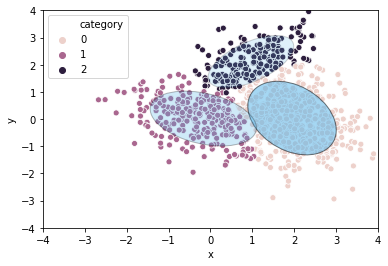

In [22]:
plt.figure()
estimator1.draw_result()
plt.show()

In [ ]:
prob [[ -6.90102487  -8.37760147 -10.20042128  -6.88231749 -24.53793139
  -10.82293033  -4.58220689  -6.04955033 -10.15165673  -3.06467509]
 [ -6.65544738  -2.84500835  -5.8170772  -29.71427415  -6.11809336
   -2.83170926 -10.87043614 -11.81302178  -4.25736806  -4.72497703]
 [ -2.60889414  -5.1049164   -3.7608544   -4.05610247  -9.87634783
   -5.18363858 -16.90343496  -2.2969964   -3.78169204  -6.77604501]]

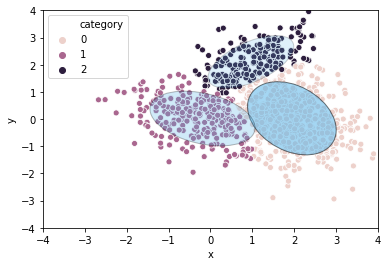

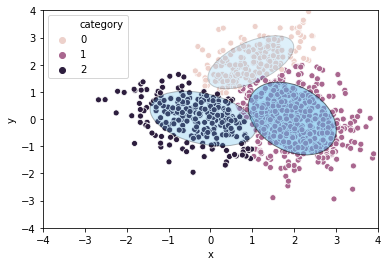

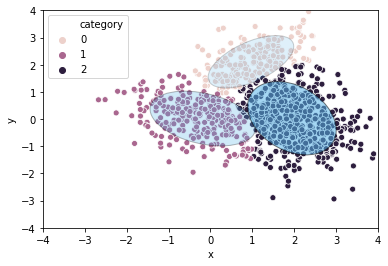

In [23]:
estimator1 = Gaussian_Mixture_Model(K=3, verbose=False, rand_state=1)
estimator1.fit(dataset[['x','y']])

plt.figure()
estimator1.draw_result()
plt.show()

estimator2 = Gaussian_Mixture_Model(K=3, verbose=False, rand_state=15)
estimator2.fit(dataset[['x','y']])
plt.figure()
estimator2.draw_result()
plt.show()

estimator3 = Gaussian_Mixture_Model(K=3, verbose=False, rand_state=100)
estimator3.fit(dataset[['x','y']])
plt.figure()
estimator3.draw_result()
plt.show()


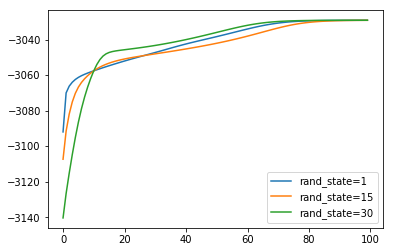

In [24]:
plt.figure()
plt.plot(estimator1._likehood[1:], label='rand_state=1')
plt.plot(estimator2._likehood[1:], label='rand_state=15' )
plt.plot(estimator3._likehood[1:], label='rand_state=30')
plt.legend()
plt.show()

In [25]:
len(estimator1._likehood[1:])

100

We can find the algorithm is not sensitive for the initial values.

In [27]:
len(estimator3._likehood)

101